In [1]:


import os
import matlab.engine # the matlab engine for python
import cv2
import numpy as np
from pathlib import Path
from diffcurve.plot_utils import plot_images, remove_frame
import matplotlib.pyplot as plt
from diffcurve.fdct2d.curvelet_2d import get_curvelet_system
from diffcurve.utils import get_project_root


project_root = get_project_root()


## Show sample image

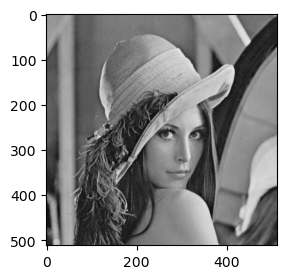

In [2]:

project_root = get_project_root()

lena_file = Path.joinpath(project_root, "data/Lena.jpg")

lena_img = cv2.imread(str(lena_file), 0).astype(float) / 255

plt.figure(figsize = (3,3))
plt.imshow(lena_img, cmap = 'gray')

# Do discrete curvelet transform in matlab

In [3]:
def get_curvelet_decomposition(img, dct_kwargs):
    eng = matlab.engine.start_matlab()
    zeros = np.zeros_like(img)
    eng.cd(str(Path.joinpath(project_root, "diffcurve/fdct2d")))
    zero_coeffs = eng.fdct_wrapping(zeros,
                                    dct_kwargs['is_real'],
                                    dct_kwargs['finest'],
                                    dct_kwargs['nbscales'],
                                    dct_kwargs['nbangles_coarse'])

    tmp = eng.fdct_wrapping(zeros,
                            dct_kwargs['is_real'],
                            dct_kwargs['finest'],
                            dct_kwargs['nbscales'],
                            dct_kwargs['nbangles_coarse'])

    img_coeffs = eng.fdct_wrapping(img,
                                   dct_kwargs['is_real'],
                                   dct_kwargs['finest'],
                                   dct_kwargs['nbscales'],
                                   dct_kwargs['nbangles_coarse'])

    all_scales_all_wedges_curvelet_coeffs = []
    for (scale_idx, curvelets_scale) in enumerate(zero_coeffs):
        print(f'scale {scale_idx}')
        for (wedge_idx, curvelet_wedge) in  enumerate(curvelets_scale):

            tmp[scale_idx][wedge_idx] = img_coeffs[scale_idx][wedge_idx]
            out = np.array(eng.ifdct_wrapping(tmp))
            all_scales_all_wedges_curvelet_coeffs.append(out)
            tmp[scale_idx][wedge_idx] = zero_coeffs[scale_idx][wedge_idx]
    return all_scales_all_wedges_curvelet_coeffs

In [4]:

dct_kwargs = {
    'is_real': 0.0, # complex-valued curvelets
    'finest': 2.0, # use wavelets at the finest level
    'nbscales': 6.0,
    'nbangles_coarse': 16.0}


matlab_decomp = get_curvelet_decomposition(lena_img, dct_kwargs)
decomp = np.array(matlab_decomp)


scale 0
scale 1
scale 2
scale 3
scale 4
scale 5


## Show some weighted curvelets

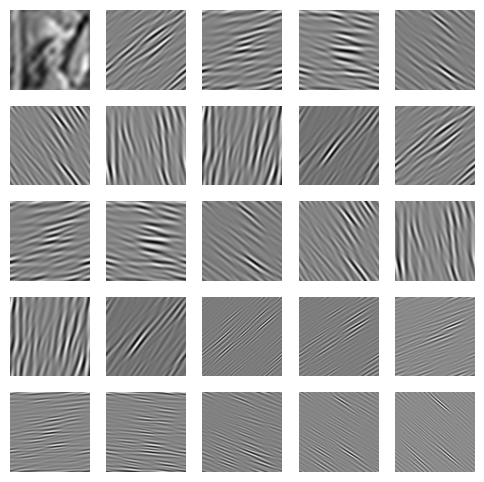

In [5]:

num_curvelets_to_show = 25

weighted_curvelets_to_show = [
    decomp[curvelet_idx].real.T for curvelet_idx in range(num_curvelets_to_show) ]


im, axes = plot_images(weighted_curvelets_to_show, nrows = 5, ncols = 5,
                       vrange = 'individual', cbar='none', cmap='gray',
                       fig_size = (6, 6))

[remove_frame(ax) for ax in axes.flatten()];

## Show the reconstructed image

MSE = 1.9629717476815235e-31


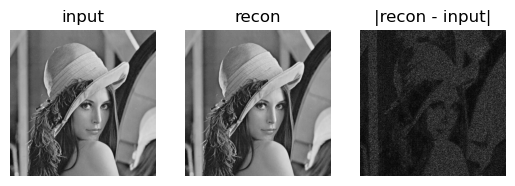

In [6]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(lena_img , cmap='gray' )
axes[0].set_title('input')

axes[1].imshow( decomp.sum(0).real, cmap='gray' )
axes[1].set_title('recon')

mse = np.mean( (decomp.sum(0).real - lena_img) ** 2 )
axes[2].imshow( np.abs(decomp.sum(0).real - lena_img), cmap='gray' )
axes[2].set_title(f'|recon - input|')

[remove_frame(ax) for ax in axes.flatten()];


print(f'MSE = { mse}')